# SD212: Graph mining
## Solution to Lab 3: Graph clustering

In this lab, you will learn to cluster a graph and interpret the results. 

## Import

In [1]:
from IPython.display import SVG

In [2]:
import numpy as np
from scipy import sparse

In [3]:
from sknetwork.data import load_netset, grid, karate_club
from sknetwork.clustering import Louvain, get_modularity
from sknetwork.ranking import PageRank
from sknetwork.linalg import normalize
from sknetwork.utils import get_membership
from sknetwork.visualization import svg_graph, svg_bigraph

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr/) collection for details):
* Openflights (graph)
* WikiVitals (directed graph)
* Cinema (bipartite graph)

In [4]:
openflights = load_netset("openflights")
wikivitals = load_netset("wikivitals")
cinema = load_netset("cinema")

Parsing files...
Done.
Parsing files...
Done.
Parsing files...
Done.


## 1. Graphs

The Louvain algorithm aims at maximizing [modularity](https://en.wikipedia.org/wiki/Modularity_(networks)).

## Grid

Consider a grid:

In [5]:
dataset = grid(9, 9, True)
adjacency = dataset.adjacency
position = dataset.position

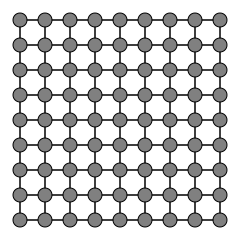

In [6]:
image = svg_graph(adjacency, position, width=200, height=200)
SVG(image)

## To do

* Cluster the graph by Louvain and return the corresponding modularity.
* Try to shuffle the nodes and observe the results.
* Find a better clustering than Louvain in terms of modularity.<br>**Hint:** Propose a simple clustering and calculate its modularity!

In [7]:
louvain = Louvain()

In [8]:
labels = louvain.fit_predict(adjacency)

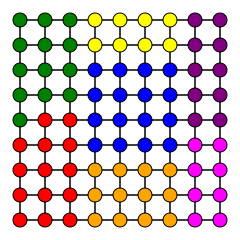

In [9]:
image = svg_graph(adjacency, position, labels=labels, width=200, height=200)
SVG(image)

In [10]:
get_modularity(adjacency, labels)

0.6220341435185185

In [11]:
n = adjacency.shape[0]
index = np.arange(n)
np.random.shuffle(index)
adjacency_shuffle = adjacency[index][:, index]

In [12]:
labels_shuffle = louvain.fit_predict(adjacency_shuffle)

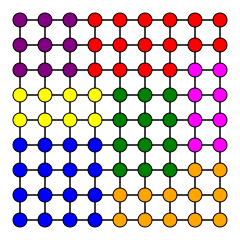

In [13]:
image = svg_graph(
    adjacency_shuffle, position[index], labels=labels_shuffle, width=200, height=200
)

SVG(image)

In [14]:
get_modularity(adjacency_shuffle, labels_shuffle)

0.6239390432098766

In [15]:
n = adjacency.shape[0]
labels = np.array([((i % 9) // 3) * 3 + (i // 9) // 3 for i in range(n)])

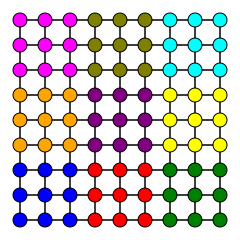

In [16]:
image = svg_graph(adjacency, position, labels=labels, width=200, height=200)
SVG(image)

In [17]:
get_modularity(adjacency, labels)

0.638454861111111

## Karate Club


The [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) provides ground-truth clusters.

In [18]:
dataset = karate_club(metadata=True)

In [19]:
adjacency = dataset.adjacency
position = dataset.position
labels_true = dataset.labels

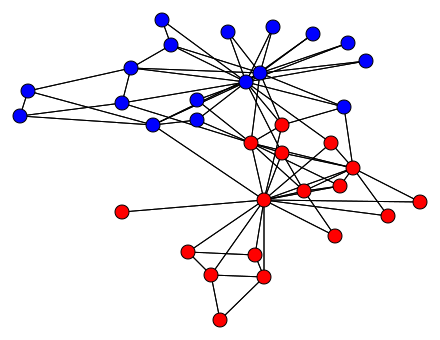

In [20]:
image = svg_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Cluster the graph by Louvain and display the labels.
* Give the modularity.
* Display the aggregate graph (use ``display_node_weight`` to show the volume of each cluster).
* Set the resolution to $\frac 1 2$ and display the new clustering. Compare with the ground truth.

In [21]:
louvain = Louvain()

In [22]:
labels = louvain.fit_predict(adjacency)

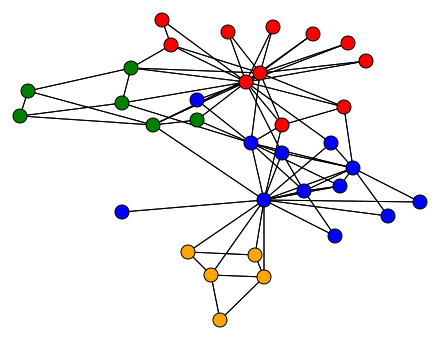

In [23]:
image = svg_graph(adjacency, position, labels=labels)
SVG(image)

In [24]:
adjacency_aggregate = louvain.aggregate_

In [25]:
average = normalize(get_membership(labels).T)
position_aggregate = average.dot(position)

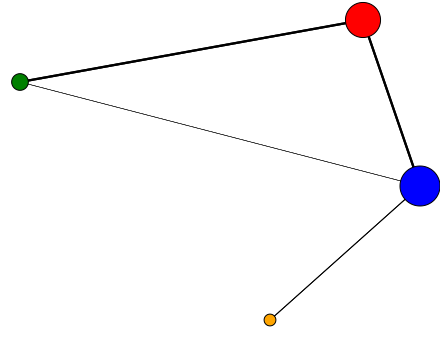

In [26]:
image = svg_graph(
    adjacency_aggregate,
    position_aggregate,
    labels=np.unique(labels),
    display_node_weight=True,
)

SVG(image)

In [27]:
louvain = Louvain(resolution=0.5)

In [28]:
labels = louvain.fit_predict(adjacency)

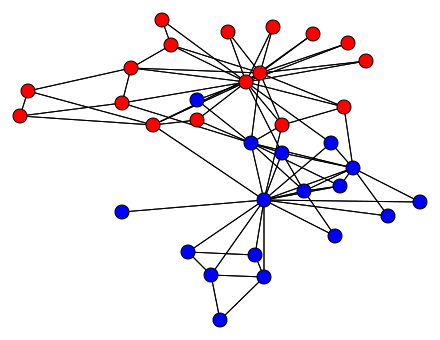

In [29]:
image = svg_graph(adjacency, position, labels=labels)
SVG(image)

In [30]:
labels_pred = labels
if np.sum(labels_pred == labels_true) < np.sum(labels_pred == 1 - labels_true):
    labels_pred = 1 - labels_pred

In [31]:
misclassified = np.argwhere(labels_pred != labels_true).ravel()

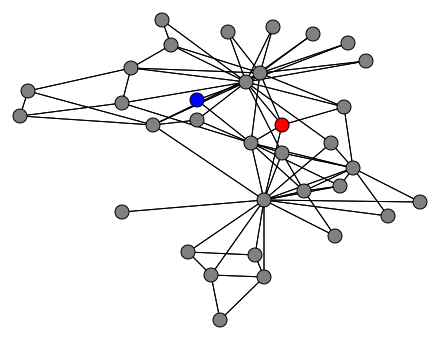

In [32]:
image = svg_graph(adjacency, position, labels={i: labels[i] for i in misclassified})
SVG(image)

## Openflights


In [33]:
dataset = openflights

In [34]:
adjacency = dataset.adjacency
position = dataset.position
names = dataset.names

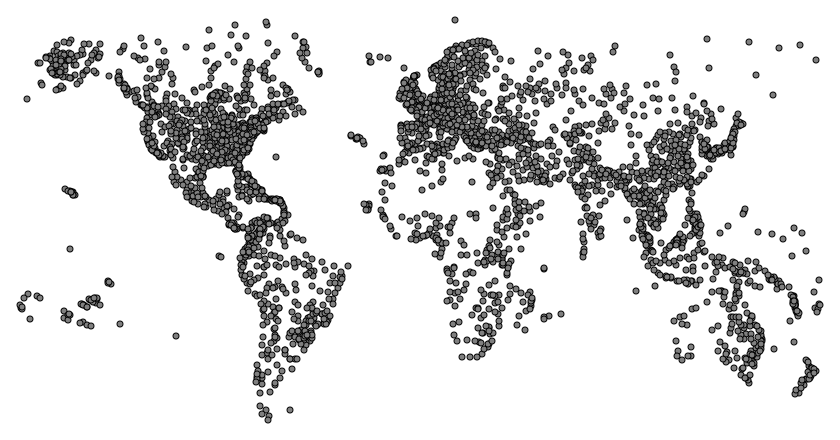

In [35]:
image = svg_graph(
    adjacency, position, width=800, height=400, node_size=3, display_edges=False
)

SVG(image)

## To do

* Display the same world map with the clusters found by Louvain (resolution 1).
* How many clusters are there?
* What is the Simpson index of this clustering? Check the function ``modularity``.
* How do you interpret the *inverse* of the Simpson index?
* List the top airport of each cluster in number of flights.
* Display the aggregate graph with the cluster volumes and the name of the top airport of each cluster.
* Display the same graph restricted to clusters with at least 100 nodes.
* Which of these clusters has the highest traffic (inside + outside)?
* Which of these clusters is the strongest?

In [36]:
louvain = Louvain()

In [37]:
labels = louvain.fit_predict(adjacency)

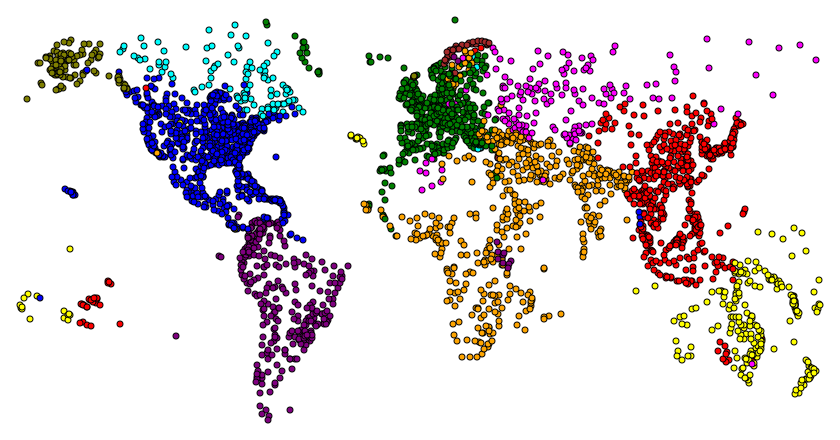

In [38]:
image = svg_graph(
    adjacency,
    position,
    width=800,
    height=400,
    node_size=3,
    labels=labels,
    display_edges=False,
    filename="openflights-louvain1",
)

SVG(image)

In [39]:
len(set(labels))

30

In [40]:
get_modularity(adjacency, labels, return_all=True)

(0.655010075624915, 0.8706267998284419, 0.21561672420352695)

In [41]:
simpson = get_modularity(adjacency, labels, return_all=True)[2]

In [42]:
# approximate number of actual clusters
1 / simpson

4.63785916279885

In [43]:
# number of significant clusters
_, counts = np.unique(labels, return_counts=True)
np.sum(counts > 100)

9

In [44]:
labels_unique, counts = np.unique(labels, return_counts=True)

In [45]:
n = adjacency.shape[0]
weights = adjacency.dot(np.ones(n))

In [46]:
top_airports = []
for label in labels_unique:
    cluster = np.argwhere(labels == label).ravel()
    top_airports.append(cluster[np.argmax(weights[cluster])])

In [47]:
adjacency_aggregate = louvain.aggregate_
average = normalize(get_membership(labels).T)
position_aggregate = average.dot(position)

In [48]:
adjacency_aggregate

<30x30 sparse matrix of type '<class 'numpy.float64'>'
	with 122 stored elements in Compressed Sparse Row format>

In [49]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int64)

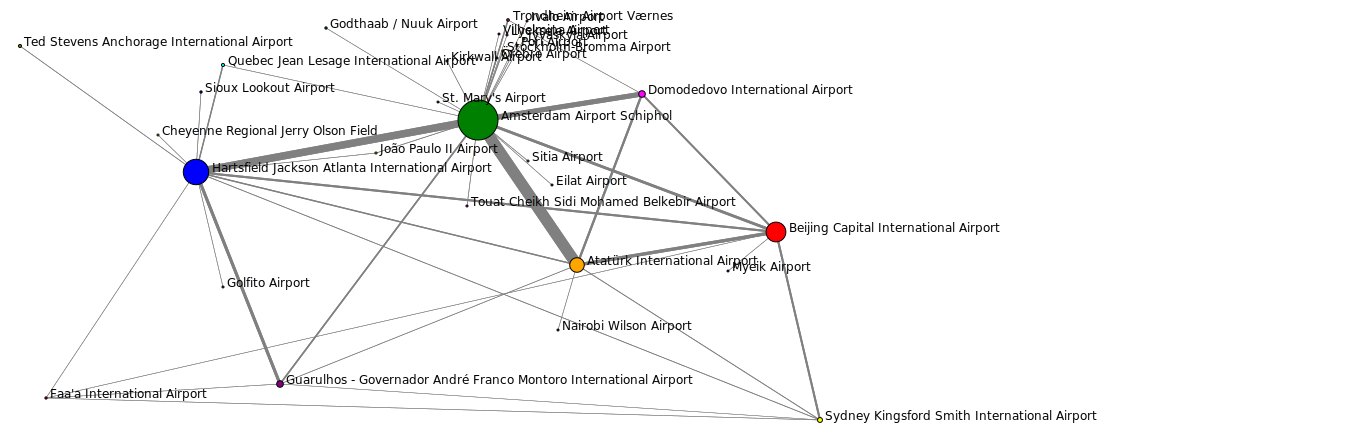

In [50]:
image = svg_graph(
    adjacency_aggregate,
    position_aggregate,
    names=names[top_airports],
    width=800,
    height=400,
    display_node_weight=True,
    edge_width_max=200,
    labels=np.unique(labels),
)

SVG(image)

In [51]:
_, counts = np.unique(labels, return_counts=True)
index = np.argwhere(counts >= 100).ravel()

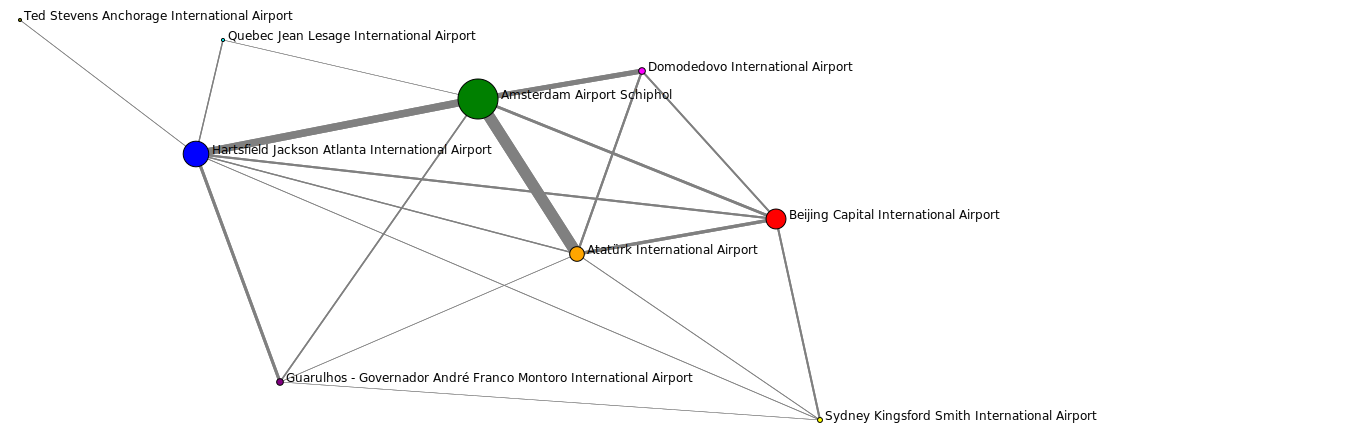

In [52]:
image = svg_graph(
    adjacency_aggregate[index][:, index],
    position_aggregate[index],
    names=names[top_airports][index],
    width=800,
    height=400,
    display_node_weight=True,
    edge_width_max=200,
    labels=np.unique(labels)[index],
)

SVG(image)

In [53]:
n_aggregate = adjacency_aggregate.shape[0]
traffics = adjacency_aggregate.dot(np.ones(n_aggregate))
strengths = adjacency_aggregate.diagonal() / traffics

In [54]:
names[top_airports][index][np.argmax(traffics[index])]

'Amsterdam Airport Schiphol'

In [55]:
names[top_airports][index][np.argmax(strengths[index])]

'Ted Stevens Anchorage International Airport'

## 2. Directed graphs

## Wikipedia Vitals

In [56]:
dataset = wikivitals

In [57]:
adjacency = dataset.adjacency
names = dataset.names

## To do

* Cluster the graph by Louvain (resolution 1).
* List the top-5 pages of each cluster in terms of Personalized PageRank.
* Display the aggregate graph with the cluster volumes and the name of the top page of each cluster.
* Display the same graph restricted to clusters with at least 100 nodes.
* Which of these clusters is the strongest? the weakest?
* Display the bipartite graph linking these clusters to their ground-truth labels.
* Display the same graph restricted to the meain ground-truth labels of each cluster, each representing at least 10% of the labels of the cluster.
* Repeat the same experiments at resolution 2.

In [58]:
louvain = Louvain(resolution=1)

In [59]:
labels = louvain.fit_predict(adjacency)

In [60]:
len(set(labels))

9

In [61]:
pagerank = PageRank()

In [62]:
top_pages = []
for label in np.unique(labels):
    scores = pagerank.fit_predict(adjacency, weights=labels == label)
    scores *= labels == label
    top_nodes = np.argsort(-scores)[:5]
    print(names[top_nodes], len(cluster))
    top_pages.append(top_nodes[0])

['Physics' 'Hydrogen' 'Oxygen' 'Kelvin' 'Albert Einstein'] 2
['Taxonomy (biology)' 'Animal' 'Plant' 'Protein' 'Species'] 2
['Latin' 'World War I' 'Roman Empire' 'Middle Ages' 'Greek language'] 2
['Christianity' 'Aristotle' 'Catholic Church' 'Plato'
 'Age of Enlightenment'] 2
['United States' 'World War II' 'Geographic coordinate system'
 'United Kingdom' 'France'] 2
['China' 'India' 'Buddhism' 'Islam' 'Chinese language'] 2
['The New York Times' 'New York City' 'Time (magazine)' 'BBC'
 'The Washington Post'] 2
['Earth' 'Atlantic Ocean' 'Europe' 'Drainage basin' 'Pacific Ocean'] 2
['Handbag' 'Hat' 'Veil' 'Uniform' 'Clothing'] 2


In [63]:
names[top_pages]

array(['Physics', 'Taxonomy (biology)', 'Latin', 'Christianity',
       'United States', 'China', 'The New York Times', 'Earth', 'Handbag'],
      dtype='<U62')

In [64]:
adjacency_aggregate = louvain.aggregate_

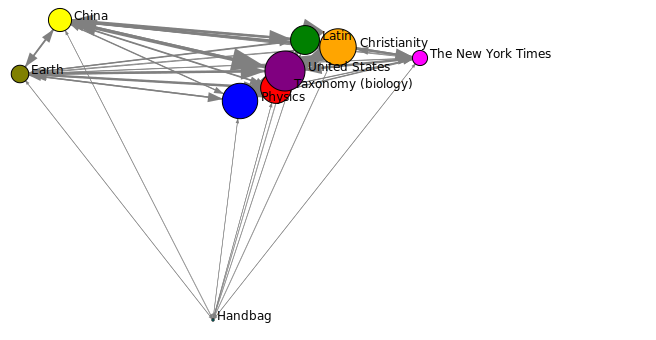

In [65]:
image = svg_graph(
    adjacency_aggregate,
    names=names[top_pages],
    display_node_weight=True,
    display_edge_weight=True,
    labels=np.unique(labels),
)

SVG(image)

In [66]:
_, counts = np.unique(labels, return_counts=True)

In [67]:
index = np.argwhere(counts >= 100).ravel()

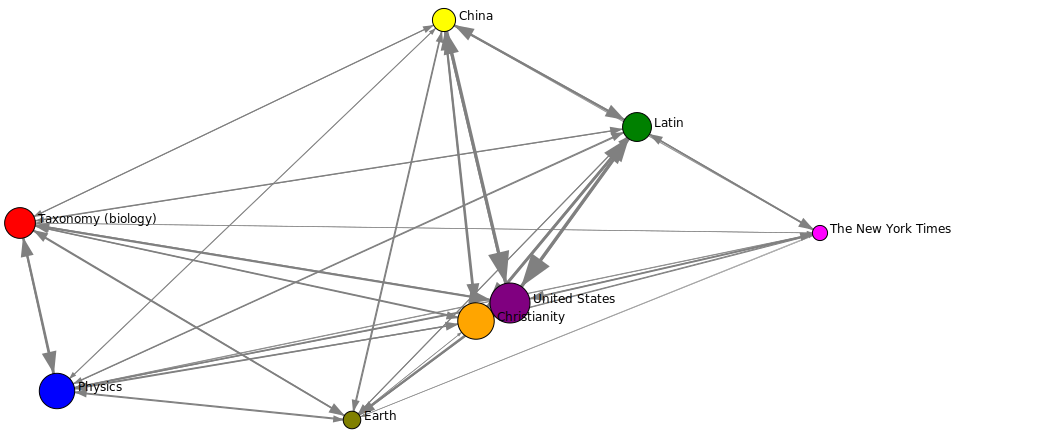

In [68]:
image = svg_graph(
    adjacency_aggregate[index][:, index],
    names=names[top_pages][index],
    width=800,
    height=400,

    display_node_weight=True,
    display_edge_weight=True,
    edge_width_max=20,
    labels=np.unique(labels)[index],
)

SVG(image)

In [69]:
_, counts = np.unique(labels, return_counts=True)

In [70]:
n_aggregate = adjacency_aggregate.shape[0]
out_links = adjacency_aggregate.dot(np.ones(n_aggregate))
strengths = adjacency_aggregate.diagonal() / out_links

In [71]:
top_pages = np.array(top_pages)

In [72]:
names[top_pages][index][np.argmax(counts[index])]

'Physics'

In [73]:
names[top_pages][index][np.argmax(strengths[index])]

'Physics'

In [74]:
names[top_pages][index][np.argmin(strengths[index])]

'China'

In [75]:
labels_true = dataset.labels
names_labels = dataset.names_labels

In [76]:
membership = (
    get_membership(labels).astype(int).T.dot(get_membership(labels_true)).tocsr()

)

In [77]:
membership.shape

(9, 11)

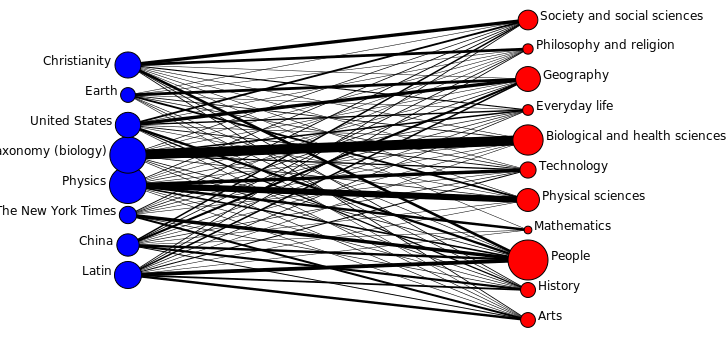

In [78]:
image = svg_bigraph(
    membership[index],
    names_row=names[top_pages][index],
    names_col=names_labels,

    display_node_weight=True,
    color_row="blue",
    color_col="red",
)

SVG(image)

In [79]:
membership_filter = membership.multiply(normalize(membership) > 0.1)

In [80]:
membership_filter

<9x11 sparse matrix of type '<class 'numpy.intc'>'
	with 25 stored elements in Compressed Sparse Row format>

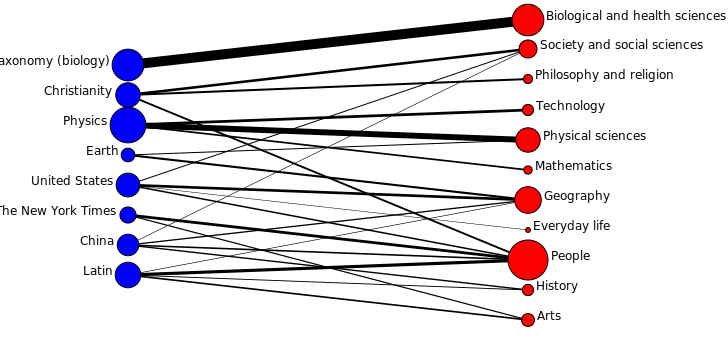

In [81]:
image = svg_bigraph(
    membership_filter[index],
    names_row=names[top_pages][index],
    names_col=names_labels,

    display_node_weight=True,
    color_row="blue",
    color_col="red",
)

SVG(image)

## 3. Bipartite graphs

## Cinema

In [82]:
dataset = cinema

In [83]:
biadjacency = dataset.biadjacency
movies = dataset.names_row
actors = dataset.names_col

## To do

* Cluster the graph by Louvain (resolution 1). 
* List the 10 largest clusters and display the names of the top-5 actors and top-5 movies of each cluster in terms of Personalized PageRank.

In [84]:
louvain = Louvain()

In [85]:
louvain.fit(biadjacency)

Louvain(resolution=1, modularity='dugue', tol_optimization=0.001, tol_aggregation=0.001, n_aggregations=-1, shuffle_nodes=False, sort_clusters=True, return_probs=True, return_aggregate=True)

In [86]:
louvain.aggregate_

<271x271 sparse matrix of type '<class 'numpy.float64'>'
	with 1256 stored elements in Compressed Sparse Row format>

In [87]:
labels_row = louvain.labels_row_
labels_col = louvain.labels_col_

In [88]:
pagerank = PageRank()

In [89]:
for label in np.unique(labels_row)[:10]:
    pagerank.fit(
        biadjacency, weights_row=labels_row == label, weights_col=labels_col == label
    )
    scores_row = pagerank.scores_row_ * (labels_row == label)
    scores_col = pagerank.scores_col_ * (labels_col == label)
    print(movies[np.argsort(-scores_row)[:5]])
    print(actors[np.argsort(-scores_col)[:5]])
    print(np.sum(labels_row == label), np.sum(labels_col == label))

['The Walking Dead (TV series)' 'Arrow (TV series)'
 'House of Cards (U.S. TV series)' 'Vikings (TV series)' 'Twin Peaks']
['Eric Roberts' 'Donald Sutherland' 'Harvey Keitel' 'Danny Trejo'
 'Robert De Niro']
17018 10884
['Paramount on Parade' 'Ziegfeld Follies' 'Mourning Becomes Electra'
 'The Crusades' 'Night Life in Hollywood']
['Harry Carey' 'Blanche Sweet' 'Roy Rogers' 'Mary Pickford'
 'Lionel Barrymore']
14442 4488
['Suyamvaram' 'Kerala Cafe' 'Paalayam' "Karinkunnam 6'S" 'Lokanathan IAS']
['Prem Nazir' 'Jagathy Sreekumar' 'Adoor Bhasi' 'Mammootty' 'Mohanlal']
11186 2262
['Kaamelott' 'Research unit' 'Hero Corp' 'Un village français'
 'Scènes de ménages']
['Louis de Funès' 'Isabelle Huppert' 'Marcello Mastroianni' 'Totò'
 'Gérard Depardieu']
8214 3892
['The Devil Rides Out' "What's Up Superdoc!" 'Unforgotten' 'Thunderbird 6'
 'The Vampire Lovers']
['Christopher Lee' 'Stewart Rome' 'John Stuart' 'James Mason'
 'Peter Cushing']
7685 4136
['Seven Samurai' 'Toei Hero Next' 'Metropolis (